<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 2 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @ZahraSorkhei, @Ali99os
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: Probabilistic Graph Forecasting with Autoregressive Decoders

This note gives a concise introduction to a temporal latent-variable model for **graph sequences** $\{G_t\}_{t=1}^T$ with $G_t=(X_t,A_t)$. It states the model, the training objective (ELBO) in a time-factorized form, the concrete likelihoods used for node features and edges, the effect of a deterministic decoder, and how to generate future graphs.



## Problem setup

We observe a sequence of graph snapshots

$$
G_t = (X_t, A_t), \quad t=1,\dots,T,
$$

where $X_t \in \mathbb{R}^{n \times d}$ stacks node feature vectors $x_t^v$ and $A_t \in \{0,1\}^{n \times n}$ is an undirected adjacency matrix (no self-loops). To capture temporal structure we introduce a latent trajectory

$$
Z_{1:T} = (Z_1, \dots, Z_T), \quad Z_t \in \mathbb{R}^m,
$$

where $Z_t$ is a global latent representation of the whole graph at time $t$.


## Generative (autoregressive latent) model

An autoregressive factorization is used:

$$
p_\theta(X_{1:T}, A_{1:T}, Z_{1:T})
= p(Z_1) \prod_{t=1}^{T-1} p_\theta(Z_{t+1}\mid Z_t)\; p_\theta(X_{t+1}, A_{t+1}\mid Z_t)
$$

Intuition: the latent $Z_t$ summarizes the state at $t$; a transition model $p_\theta(Z_{t+1}\mid Z_t)$ evolves it; conditioned on the current latent we predict the *next* snapshot $(X_{t+1}, A_{t+1})$.

We approximate the true posterior with an amortized encoder (e.g. a GNN+RNN):

$$
q_\phi(Z_t \mid X_{1:t}, A_{1:t}) \quad \text{(often factorized across $t$ for amortization).}
$$


## Variational lower bound (ELBO) — time decomposition

Using the variational approximation

$$
q_\phi(Z_{1:T}\mid X_{1:T},A_{1:T}) = \prod_{t=1}^T q_\phi(Z_t \mid X_{1:t},A_{1:t}),
$$

the marginal log-likelihood admits the ELBO:

$$
\log p_\theta(X_{1:T}, A_{1:T}) \ge
\mathbb{E}_{q_\phi} \Big[ \sum_{t=1}^{T-1} \log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) \Big]
- \mathrm{KL}\big(q_\phi(Z_1 \mid X_1, A_1) \,\|\, p(Z_1)\big)
- \sum_{t=1}^{T-1} \mathbb{E}_{q_\phi} \Big[ \mathrm{KL}\big(q_\phi(Z_{t+1}\mid X_{1:t+1}, A_{1:t+1}) \,\|\, p_\theta(Z_{t+1}\mid Z_t)\big) \Big].
$$

Thus the objective is a sum over time: per-step reconstruction terms plus per-step KL penalties that align the encoder's posterior with the learned transition prior.



## Explicit reconstruction likelihoods

If the decoder factorizes into Gaussian node-features and Bernoulli edges:

- **Node features (per node $v$)**

$$
p_\theta(x_{t+1}^v \mid Z_t) = \mathcal{N}(x_{t+1}^v \mid \mu_\theta^v(Z_t), \Sigma_\theta^v(Z_t)),
$$

hence the feature log-likelihood (for all nodes) is

$$
\log p_\theta(X_{t+1} \mid Z_t)
= -\frac{1}{2} \sum_{v=1}^n \Big[ (x_{t+1}^v - \mu_\theta^v)^\top (\Sigma_\theta^v)^{-1} (x_{t+1}^v - \mu_\theta^v) + \log \det(2 \pi \Sigma_\theta^v) \Big].
$$

(In practice $\Sigma^v$ is taken diagonal or shared for numerical stability.)

- **Edges (for unordered pairs $u<v$)**

$$
p_\theta(A_{t+1} \mid Z_t) = \prod_{u<v} \mathrm{Bernoulli}\big(A_{t+1}^{uv} \mid \pi_\theta^{uv}(Z_t)\big),
$$

so

$$
\log p_\theta(A_{t+1} \mid Z_t) = \sum_{u<v} \Big[ A_{uv} \log \pi_{uv} + (1-A_{uv}) \log (1-\pi_{uv}) \Big].
$$

Combine them:

$$
\log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) = \log p_\theta(X_{t+1} \mid Z_t) + \log p_\theta(A_{t+1} \mid Z_t).
$$


## Deterministic decoder

If the decoder is deterministic (e.g. $X_{t+1}=f_\theta(Z_t)$, $A_{t+1}=g_\theta(Z_t)$ or equivalently Gaussian with vanishing variance), then:

- The likelihood becomes a Dirac (or degenerate Gaussian); log-likelihood is $-\infty$ off the model manifold — numerically unstable.
- Deterministic decoders cannot model multimodality: a single $Z_t$ maps to a single snapshot, so they fail when the conditional distribution is multi-valued.
- Training tends to overfit (model memorizes) or produce poor uncertainty calibration. Probabilistic decoders (non-zero variance, Bernoulli edges) are preferred for stable likelihood-based training and to capture uncertainty/diversity.


## Generating future graphs

Given observed history $X_{1:T}, A_{1:T}$:

1. Infer the posterior at final time: $q_\phi(Z_T \mid X_{1:T}, A_{1:T})$ and sample $z_T \sim q_\phi$ (or use the posterior mean).
2. For $h=1$ to $H$:
   - Sample latent: $z_{T+h} \sim p_\theta(Z_{T+h} \mid z_{T+h-1})$.
   - Sample (or take mean of) snapshot: $(\tilde X_{T+h}, \tilde A_{T+h}) \sim p_\theta(\cdot \mid z_{T+h-1})$ (or use the decoder mean).





In [ ]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 1) Synthetic dynamic graph dataset
**Goal:**  
Create dynamic graphs using SBM with Gaussian node features.

**Hints:**  
- `generate_sbm`: adjacency with `p_in` (intra) and `p_out` (inter) edges.  
- `generate_features`: node features from `N(μ_k, Σ_k)` per community.  
- `generate_sequence`: simulate T timesteps with drift and edge flips.  
- `_getitem_` / `_len_`: return sequences.  
- `collate_fn`: batch multiple sequences.

**Output:**  
- `X_seq`: `[T, n_nodes, feat_dim]`  
- `A_seq`: `[T, n_nodes, n_nodes]`

In [ ]:
## TO DO

class SyntheticGraphDataset(Dataset):
    """
    Generate synthetic evolving graphs.
    - Each sequence has T snapshots.
    - Node features: random walk.
    - Edges: flip with small probability.
    """
    def __init__(self, n_nodes=30, feat_dim=4, T=40, n_seq=200, p_flip=0.03):


    def generate_sequence(self):


    def _len_(self):


    def _getitem_(self, idx):



def collate_fn(batch):


## 2) Encoder, Prior, Decoder

### SimpleGraphEncoder
Aggregates node features and degree statistics.  
Computes graph-level latent embeddings `mu` and `logvar` for VAE.  
No external graph libraries required; uses only PyTorch.

### TransitionPrior
Models the latent temporal evolution `p(Z_{t+1} | Z_t)` as a Gaussian.  
Produces mean and variance for autoregressive sampling in VAE.

### Decoder
Reconstructs node features and adjacency matrices from latent `Z_t`.  
Uses node embeddings combined with latent vectors for feature decoding.  
Produces edge logits for Bernoulli reconstruction of adjacency.  
Supports probabilistic reconstruction via Gaussian features + Bernoulli edges.

In [ ]:
## TO DO

class SimpleGraphEncoder(nn.Module):
    """
    Simple encoder that aggregates node features and graph degree stats.
    No torch_geometric needed.
    """

class TransitionPrior(nn.Module):
    """ p(Z_{t+1}|Z_t) Gaussian """



class Decoder(nn.Module):
    """ Decode node features and edges from Z_t """



`reparameterize`: samples latent variable using the reparameterization trick.  
`kl_gauss`: closed-form KL divergence between two Gaussians.  
`nll_gaussian`: negative log-likelihood for node features.  
`nll_bernoulli`: negative log-likelihood (binary cross-entropy) for edges.

In [ ]:
## TO DO

def reparameterize(mu, logvar):


def kl_gauss(mu_q, logvar_q, mu_p, logvar_p):
    """ closed-form KL(q||p) """


def nll_gaussian(x, mu, logvar):



def nll_bernoulli(logits, target):


## 4) TemporalGraphVAE
Define the Temporal Graph VAE model.  
- Encode node features & adjacency into latent `z`.  
- Model transitions `p(z_{t+1}|z_t)`.  
- Decode `z` to reconstruct node features and edges.  
- Compute ELBO (reconstruction + KL) for training.

In [ ]:
## TO DO
class TemporalGraphVAE(nn.Module):
    def __init__(self, n_nodes, feat_dim, z_dim=16):
        super().__init__()

    def forward(self, X_seq, A_seq, kl_weight=1.0):


## 5) Visualization helpers

In [ ]:
def visualize_graphs(A_true, A_recon_probs, communities, epoch, K, p_in, p_out):
    A_recon_bin = (A_recon_probs >= 0.5).astype(int)
    G_true, G_recon = nx.from_numpy_array(A_true), nx.from_numpy_array(A_recon_bin)
    pos = nx.spring_layout(G_true, seed=42)
    plt.figure(figsize=(9, 4))
    plt.suptitle(f"SBM Graphs (Epoch {epoch})\n"
                 f"K={K}, Intra={p_in}, Inter={p_out}\n"
                 f"In each component: X~N(μ_k, Σ_k)", fontsize=10)
    plt.subplot(1, 2, 1)
    nx.draw(G_true, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("True graph")
    plt.subplot(1, 2, 2)
    nx.draw(G_recon, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("Reconstructed (p≥0.5)")
    plt.tight_layout()
    plt.show()


## 6) Training
Train the Temporal Graph VAE.  
- Loop over epochs and batches.  
- Forward pass, compute loss, backprop, optimizer step.  
- Track and print losses (`Total`, `Recon`, `KL`).  
- Optionally visualize true vs reconstructed graphs every `vis_interval`.

In [ ]:
## TO DO
def train_model(vis_interval=5, epochs=30):

## 7) Testing
Evaluate the trained model on sample sequences.  
- Encode last snapshot, decode to get reconstructed adjacency/features.  
- Compute simple metrics (e.g., edge accuracy).  
- Visualize true vs reconstructed graphs for verification.

In [ ]:
## TO DO
def test_model(model, dataset):

## 8) Train and Test


**The final result can be much better than the displayed result.**

Device: cuda
Epoch 001 | Loss: 714349.09 | Recon: 714326.27 | KL: 228.12 | kl_w: 0.10
Epoch 002 | Loss: 688102.43 | Recon: 688083.70 | KL: 93.61 | kl_w: 0.20
Epoch 003 | Loss: 662989.20 | Recon: 662962.74 | KL: 88.17 | kl_w: 0.30
Epoch 004 | Loss: 638302.11 | Recon: 638265.79 | KL: 90.82 | kl_w: 0.40
Epoch 005 | Loss: 613118.10 | Recon: 613060.64 | KL: 114.91 | kl_w: 0.50


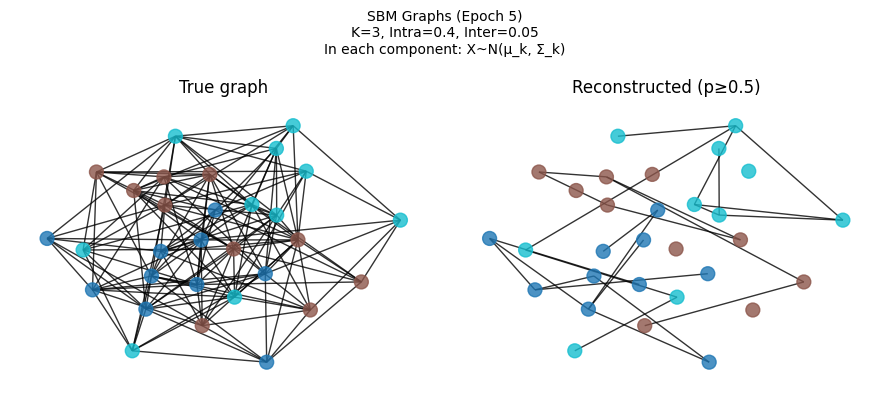

Epoch 006 | Loss: 592923.46 | Recon: 592825.02 | KL: 164.05 | kl_w: 0.60
Epoch 007 | Loss: 582083.11 | Recon: 581922.97 | KL: 228.76 | kl_w: 0.70
Epoch 008 | Loss: 578404.08 | Recon: 578188.13 | KL: 269.93 | kl_w: 0.80
Epoch 009 | Loss: 574667.93 | Recon: 574431.85 | KL: 262.31 | kl_w: 0.90
Epoch 010 | Loss: 569592.03 | Recon: 569344.00 | KL: 248.03 | kl_w: 1.00


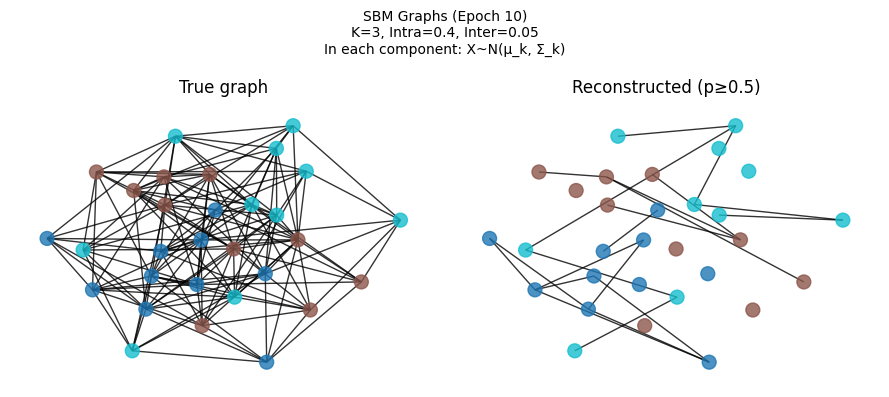

Epoch 011 | Loss: 567968.10 | Recon: 567716.83 | KL: 251.28 | kl_w: 1.00
Epoch 012 | Loss: 566882.55 | Recon: 566609.91 | KL: 272.64 | kl_w: 1.00
Epoch 013 | Loss: 565581.87 | Recon: 565285.66 | KL: 296.21 | kl_w: 1.00
Epoch 014 | Loss: 563715.62 | Recon: 563392.97 | KL: 322.64 | kl_w: 1.00
Epoch 015 | Loss: 562651.34 | Recon: 562304.86 | KL: 346.47 | kl_w: 1.00


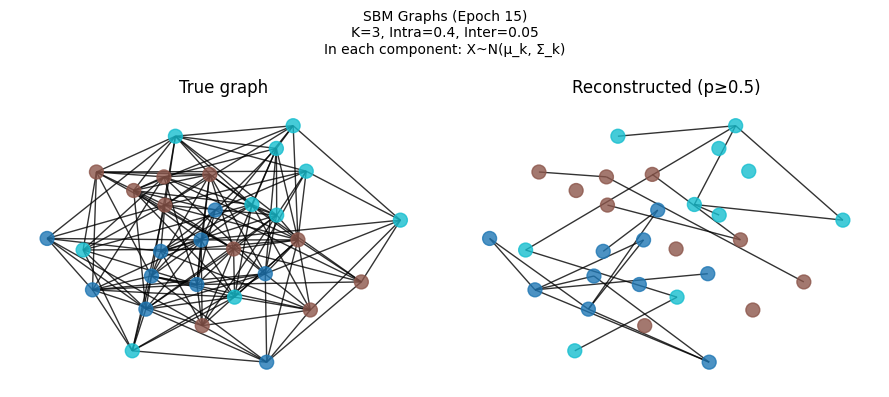

Epoch 016 | Loss: 561299.14 | Recon: 560935.55 | KL: 363.59 | kl_w: 1.00
Epoch 017 | Loss: 560617.93 | Recon: 560233.01 | KL: 384.92 | kl_w: 1.00
Epoch 018 | Loss: 559993.54 | Recon: 559587.32 | KL: 406.22 | kl_w: 1.00
Epoch 019 | Loss: 558891.50 | Recon: 558459.35 | KL: 432.14 | kl_w: 1.00
Epoch 020 | Loss: 558104.26 | Recon: 557645.58 | KL: 458.68 | kl_w: 1.00


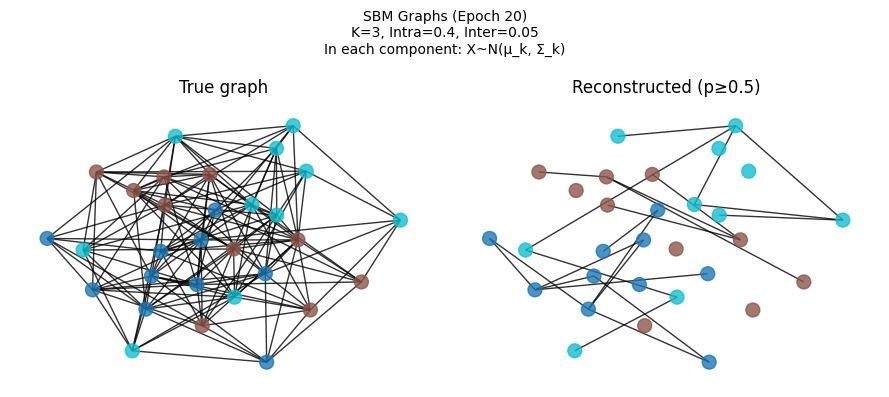

Epoch 021 | Loss: 557421.80 | Recon: 556909.04 | KL: 512.75 | kl_w: 1.00
Epoch 022 | Loss: 557133.05 | Recon: 556607.59 | KL: 525.46 | kl_w: 1.00
Epoch 023 | Loss: 556448.29 | Recon: 555909.71 | KL: 538.58 | kl_w: 1.00
Epoch 024 | Loss: 555477.12 | Recon: 554902.64 | KL: 574.48 | kl_w: 1.00
Epoch 025 | Loss: 554944.24 | Recon: 554342.03 | KL: 602.21 | kl_w: 1.00


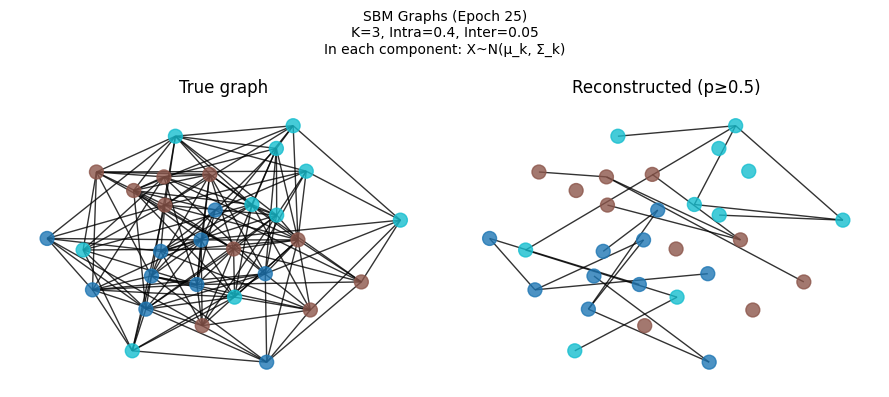

Epoch 026 | Loss: 553838.62 | Recon: 553210.01 | KL: 628.62 | kl_w: 1.00
Epoch 027 | Loss: 554202.72 | Recon: 553547.33 | KL: 655.39 | kl_w: 1.00
Epoch 028 | Loss: 553385.31 | Recon: 552709.93 | KL: 675.39 | kl_w: 1.00
Epoch 029 | Loss: 552878.24 | Recon: 552164.73 | KL: 713.52 | kl_w: 1.00
Epoch 030 | Loss: 551940.03 | Recon: 551215.35 | KL: 724.68 | kl_w: 1.00


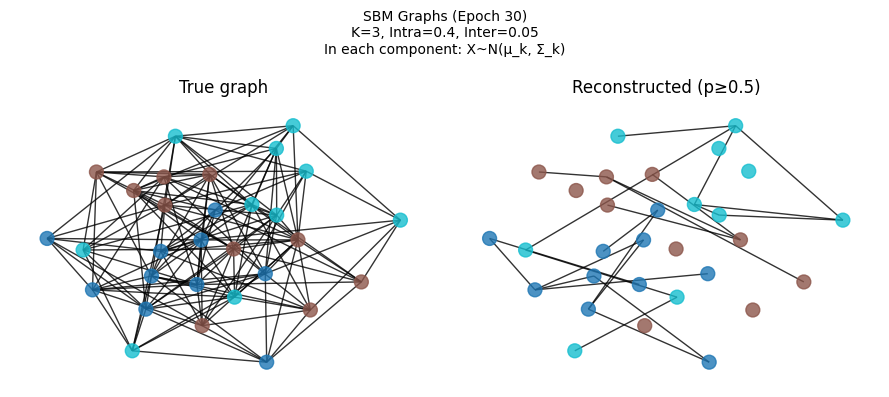

Epoch 031 | Loss: 551547.95 | Recon: 550804.21 | KL: 743.75 | kl_w: 1.00
Epoch 032 | Loss: 551205.86 | Recon: 550437.49 | KL: 768.36 | kl_w: 1.00
Epoch 033 | Loss: 550786.58 | Recon: 549997.80 | KL: 788.77 | kl_w: 1.00
Epoch 034 | Loss: 550361.19 | Recon: 549528.44 | KL: 832.74 | kl_w: 1.00
Epoch 035 | Loss: 549926.05 | Recon: 549084.65 | KL: 841.39 | kl_w: 1.00


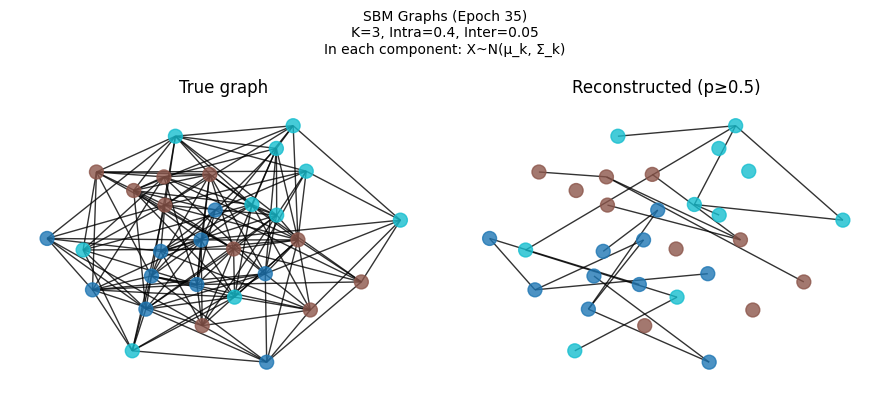

Epoch 036 | Loss: 549295.17 | Recon: 548447.71 | KL: 847.47 | kl_w: 1.00
Epoch 037 | Loss: 548923.46 | Recon: 548060.01 | KL: 863.45 | kl_w: 1.00
Epoch 038 | Loss: 548181.80 | Recon: 547306.11 | KL: 875.70 | kl_w: 1.00
Epoch 039 | Loss: 547928.69 | Recon: 547039.09 | KL: 889.61 | kl_w: 1.00
Epoch 040 | Loss: 547572.31 | Recon: 546676.11 | KL: 896.20 | kl_w: 1.00


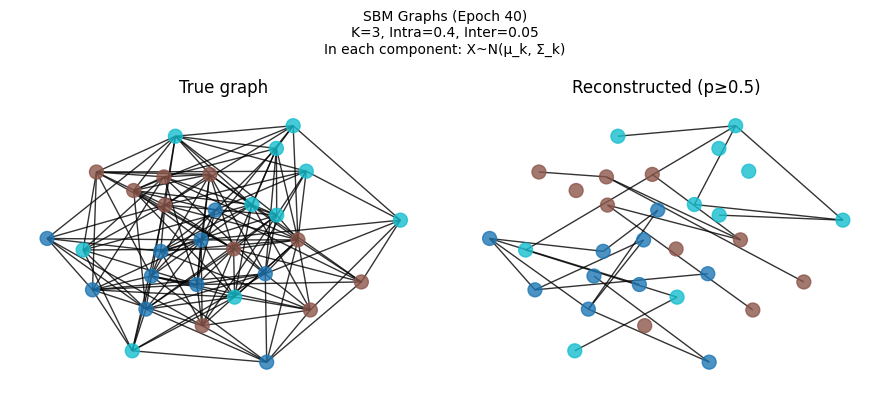

Epoch 041 | Loss: 546721.11 | Recon: 545801.81 | KL: 919.29 | kl_w: 1.00
Epoch 042 | Loss: 546697.12 | Recon: 545695.86 | KL: 1001.26 | kl_w: 1.00
Epoch 043 | Loss: 546038.04 | Recon: 545076.96 | KL: 961.08 | kl_w: 1.00
Epoch 044 | Loss: 545401.62 | Recon: 544458.73 | KL: 942.88 | kl_w: 1.00
Epoch 045 | Loss: 545072.05 | Recon: 544107.34 | KL: 964.71 | kl_w: 1.00


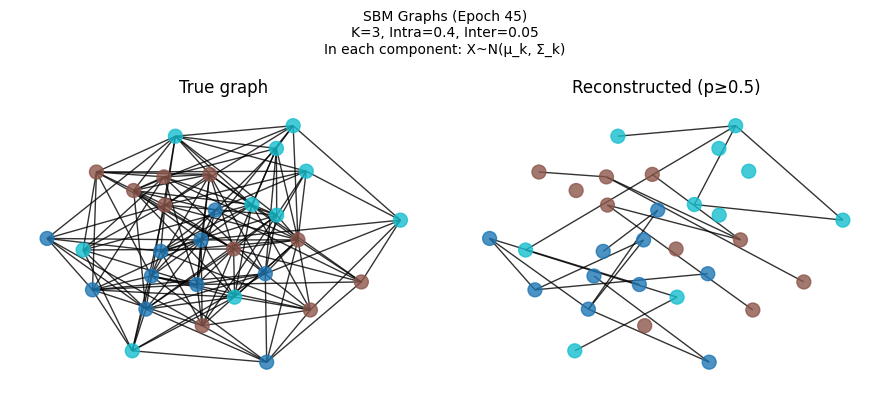

Epoch 046 | Loss: 544631.71 | Recon: 543632.00 | KL: 999.70 | kl_w: 1.00
Epoch 047 | Loss: 543894.76 | Recon: 542932.63 | KL: 962.13 | kl_w: 1.00
Epoch 048 | Loss: 544017.06 | Recon: 543017.31 | KL: 999.76 | kl_w: 1.00
Epoch 049 | Loss: 543165.39 | Recon: 542154.01 | KL: 1011.38 | kl_w: 1.00
Epoch 050 | Loss: 542487.78 | Recon: 541478.65 | KL: 1009.12 | kl_w: 1.00


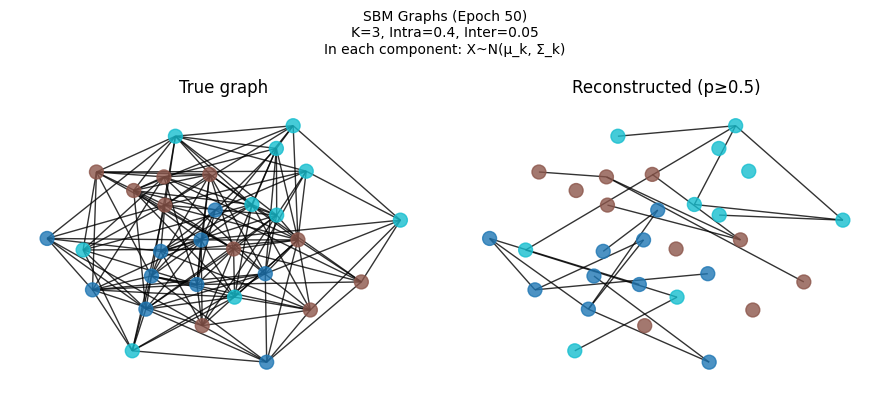

Epoch 051 | Loss: 542286.84 | Recon: 541257.36 | KL: 1029.48 | kl_w: 1.00
Epoch 052 | Loss: 541498.55 | Recon: 540466.17 | KL: 1032.39 | kl_w: 1.00
Epoch 053 | Loss: 541358.39 | Recon: 540306.39 | KL: 1051.99 | kl_w: 1.00
Epoch 054 | Loss: 540658.06 | Recon: 539577.18 | KL: 1080.88 | kl_w: 1.00
Epoch 055 | Loss: 540044.71 | Recon: 538981.04 | KL: 1063.67 | kl_w: 1.00


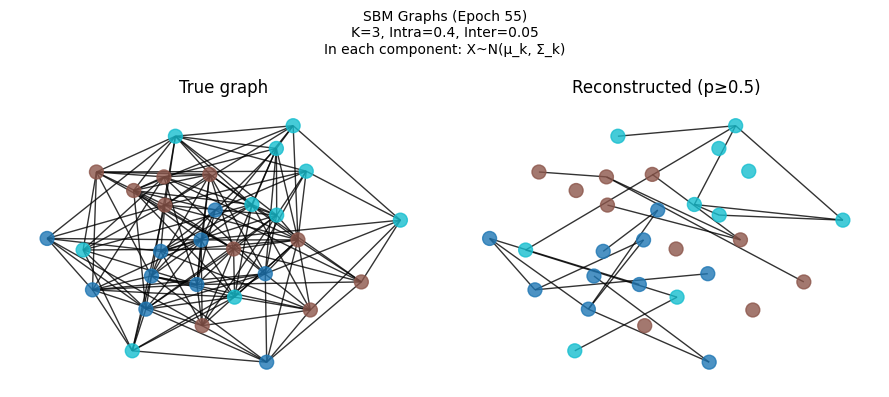

Epoch 056 | Loss: 539724.06 | Recon: 538679.59 | KL: 1044.47 | kl_w: 1.00
Epoch 057 | Loss: 539206.03 | Recon: 538153.05 | KL: 1052.97 | kl_w: 1.00
Epoch 058 | Loss: 538625.80 | Recon: 537547.78 | KL: 1078.02 | kl_w: 1.00
Epoch 059 | Loss: 538185.47 | Recon: 537093.22 | KL: 1092.24 | kl_w: 1.00
Epoch 060 | Loss: 537744.14 | Recon: 536622.54 | KL: 1121.60 | kl_w: 1.00


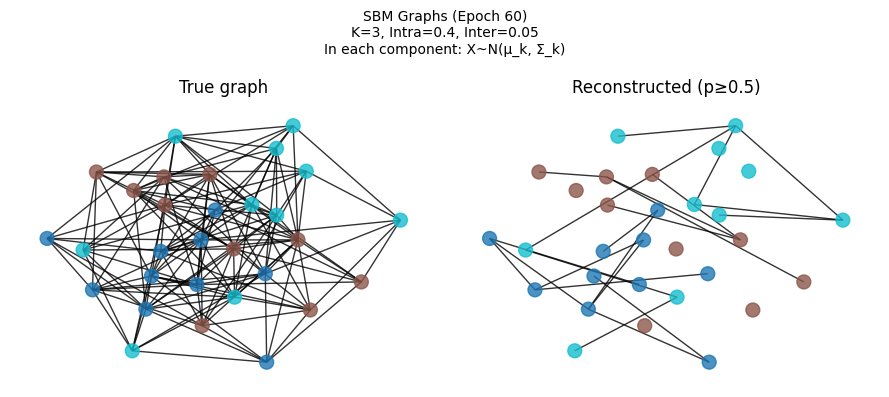

Epoch 061 | Loss: 536850.07 | Recon: 535739.84 | KL: 1110.22 | kl_w: 1.00
Epoch 062 | Loss: 536497.03 | Recon: 535353.64 | KL: 1143.39 | kl_w: 1.00
Epoch 063 | Loss: 535857.88 | Recon: 534709.11 | KL: 1148.76 | kl_w: 1.00
Epoch 064 | Loss: 535157.78 | Recon: 533991.83 | KL: 1165.94 | kl_w: 1.00
Epoch 065 | Loss: 534727.57 | Recon: 533517.32 | KL: 1210.26 | kl_w: 1.00


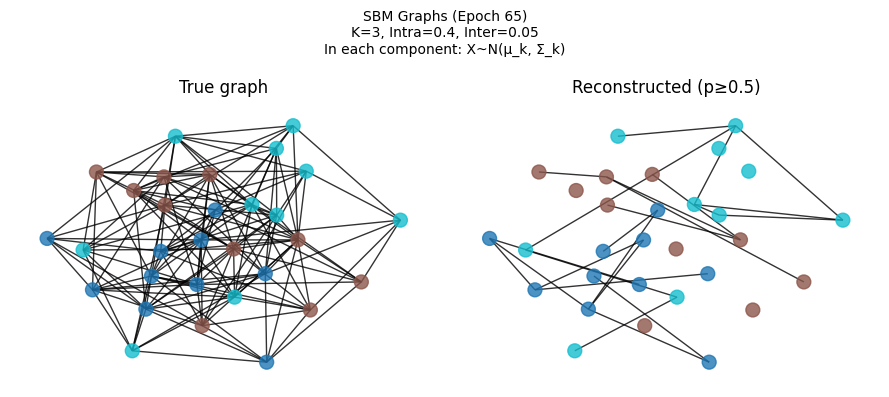

Epoch 066 | Loss: 534085.47 | Recon: 532872.16 | KL: 1213.32 | kl_w: 1.00
Epoch 067 | Loss: 533443.26 | Recon: 532229.09 | KL: 1214.18 | kl_w: 1.00
Epoch 068 | Loss: 532822.50 | Recon: 531592.64 | KL: 1229.87 | kl_w: 1.00
Epoch 069 | Loss: 532686.74 | Recon: 531412.66 | KL: 1274.09 | kl_w: 1.00
Epoch 070 | Loss: 531818.56 | Recon: 530518.23 | KL: 1300.32 | kl_w: 1.00


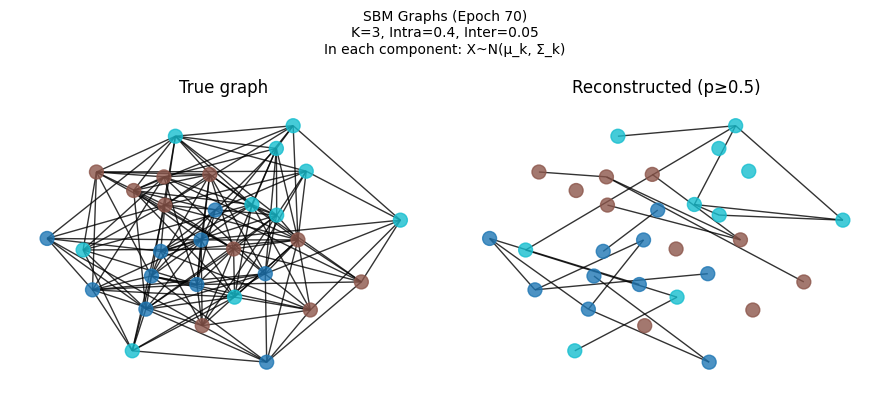

Epoch 071 | Loss: 531213.82 | Recon: 529874.74 | KL: 1339.10 | kl_w: 1.00
Epoch 072 | Loss: 530317.61 | Recon: 529016.00 | KL: 1301.62 | kl_w: 1.00
Epoch 073 | Loss: 529966.80 | Recon: 528631.79 | KL: 1335.01 | kl_w: 1.00
Epoch 074 | Loss: 529377.55 | Recon: 528045.08 | KL: 1332.47 | kl_w: 1.00
Epoch 075 | Loss: 528950.64 | Recon: 527575.21 | KL: 1375.43 | kl_w: 1.00


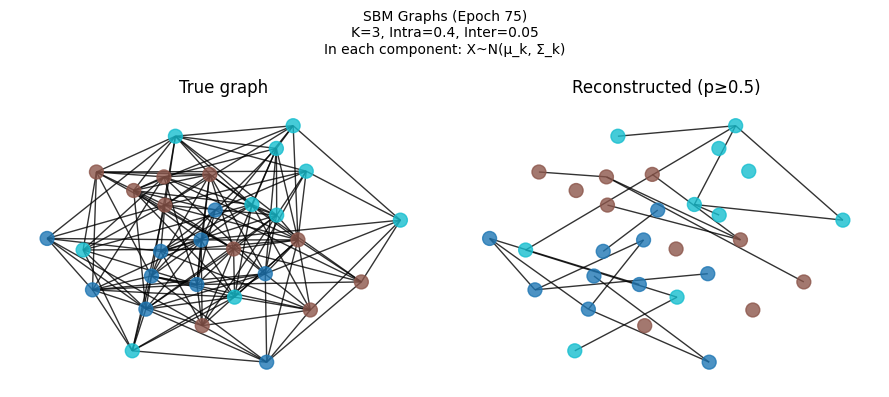

Epoch 076 | Loss: 528184.82 | Recon: 526848.15 | KL: 1336.67 | kl_w: 1.00
Epoch 077 | Loss: 527606.51 | Recon: 526251.05 | KL: 1355.47 | kl_w: 1.00
Epoch 078 | Loss: 526878.56 | Recon: 525495.41 | KL: 1383.16 | kl_w: 1.00
Epoch 079 | Loss: 526468.60 | Recon: 525054.06 | KL: 1414.53 | kl_w: 1.00
Epoch 080 | Loss: 525914.90 | Recon: 524509.68 | KL: 1405.22 | kl_w: 1.00


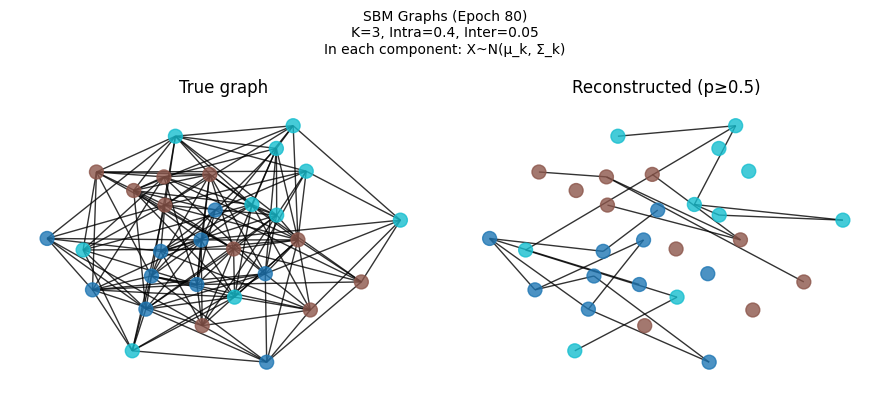

Epoch 081 | Loss: 525380.54 | Recon: 523943.22 | KL: 1437.31 | kl_w: 1.00
Epoch 082 | Loss: 525057.03 | Recon: 523554.31 | KL: 1502.73 | kl_w: 1.00
Epoch 083 | Loss: 524588.35 | Recon: 523078.02 | KL: 1510.33 | kl_w: 1.00
Epoch 084 | Loss: 524123.90 | Recon: 522573.93 | KL: 1549.96 | kl_w: 1.00
Epoch 085 | Loss: 523715.26 | Recon: 522072.04 | KL: 1643.22 | kl_w: 1.00


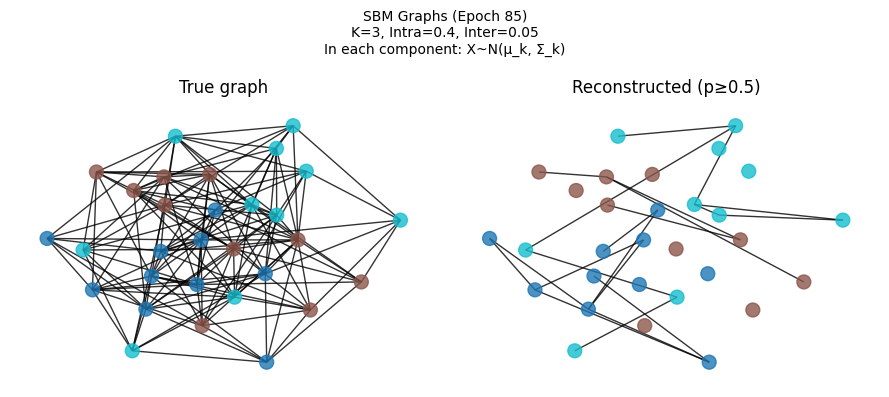

Epoch 086 | Loss: 523374.99 | Recon: 521811.76 | KL: 1563.22 | kl_w: 1.00
Epoch 087 | Loss: 522953.66 | Recon: 521387.33 | KL: 1566.33 | kl_w: 1.00
Epoch 088 | Loss: 522559.37 | Recon: 520950.13 | KL: 1609.23 | kl_w: 1.00
Epoch 089 | Loss: 522078.46 | Recon: 520504.36 | KL: 1574.11 | kl_w: 1.00
Epoch 090 | Loss: 521689.64 | Recon: 520063.78 | KL: 1625.86 | kl_w: 1.00


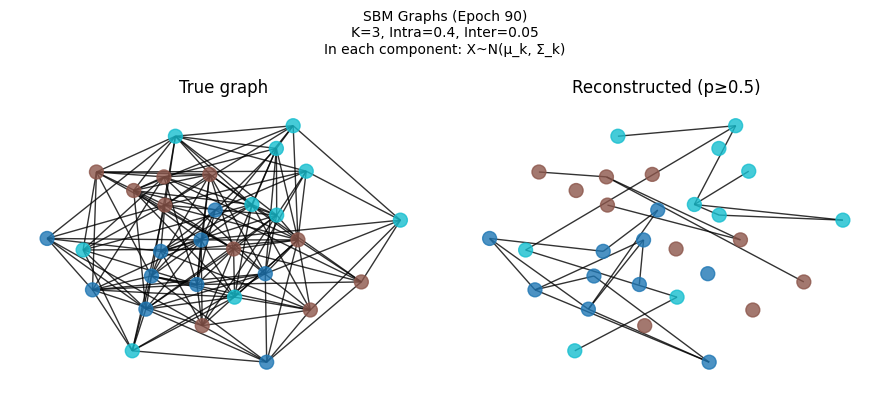

Epoch 091 | Loss: 521358.48 | Recon: 519697.33 | KL: 1661.16 | kl_w: 1.00
Epoch 092 | Loss: 520894.49 | Recon: 519220.84 | KL: 1673.66 | kl_w: 1.00
Epoch 093 | Loss: 520520.10 | Recon: 518827.72 | KL: 1692.38 | kl_w: 1.00
Epoch 094 | Loss: 520013.04 | Recon: 518290.54 | KL: 1722.51 | kl_w: 1.00
Epoch 095 | Loss: 519618.24 | Recon: 517870.17 | KL: 1748.07 | kl_w: 1.00


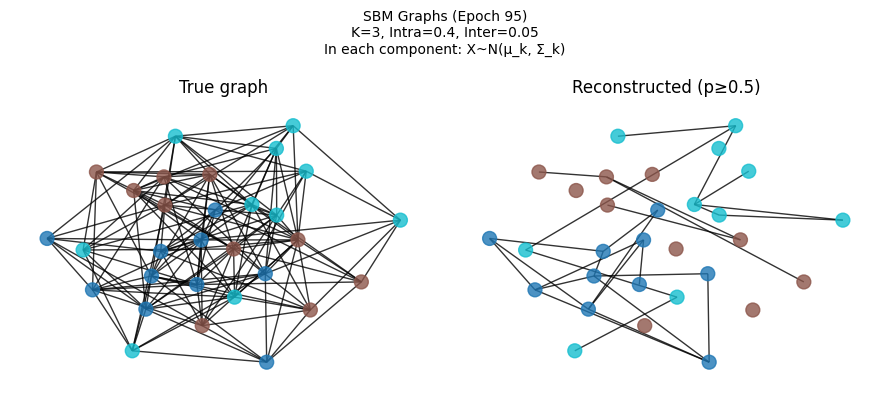

Epoch 096 | Loss: 519224.64 | Recon: 517472.04 | KL: 1752.60 | kl_w: 1.00
Epoch 097 | Loss: 518782.62 | Recon: 517000.68 | KL: 1781.94 | kl_w: 1.00
Epoch 098 | Loss: 518438.17 | Recon: 516769.84 | KL: 1668.32 | kl_w: 1.00
Epoch 099 | Loss: 517814.61 | Recon: 516192.76 | KL: 1621.84 | kl_w: 1.00
Epoch 100 | Loss: 517443.63 | Recon: 515795.55 | KL: 1648.07 | kl_w: 1.00


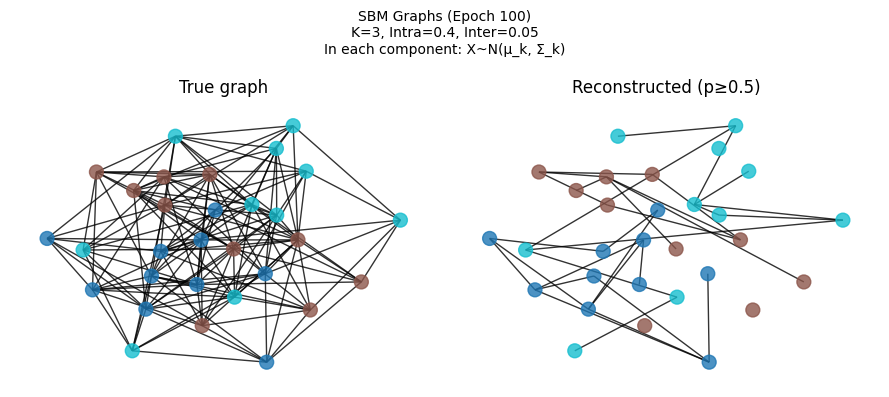

✅ Model saved: temporal_graph_vae_sbm.pth
Test accuracy (edge match): 68.44%


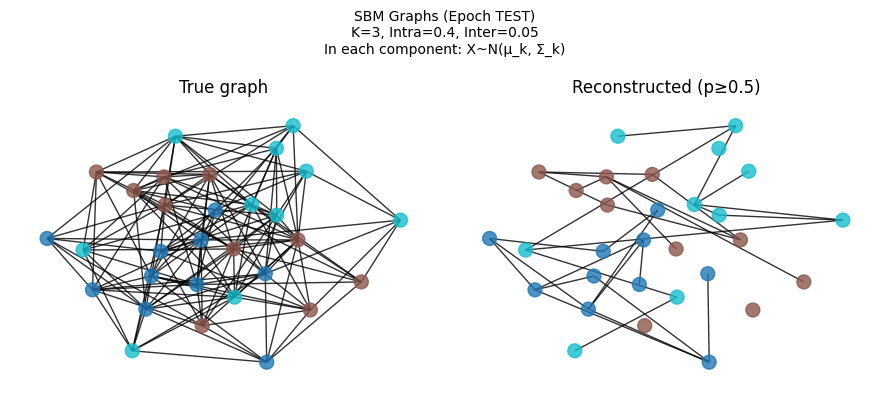

In [2]:

if __name__ == "__main__":
    model, dataset = train_model(vis_interval=5, epochs=100)
    test_model(model, dataset)


# Question 2: Conditional Variational Autoencoder (CVAE) for Digit Generation

This note introduces a **Conditional Variational Autoencoder (CVAE)** for image generation on the **MNIST** dataset. The goal is to learn a deep latent-variable model that can synthesize digits conditioned on a desired label—e.g., generate a “2” on demand—and optionally modulate the writing style.


## **Problem setup**

We observe training pairs of handwritten digits and their class labels
$$
\mathcal{D} = {(x^{(i)}, y^{(i)})}_{i=1}^N,
$$
where $x^{(i)} \in \mathbb{R}^{28\times28}$ is an image and $y^{(i)} \in {0,\dots,9}$ is the corresponding digit label.
Our goal is to model the conditional data distribution
$$
p_\theta(x \mid y),
$$
so that, given any label $y$, the model can generate realistic samples $x$ of that digit.



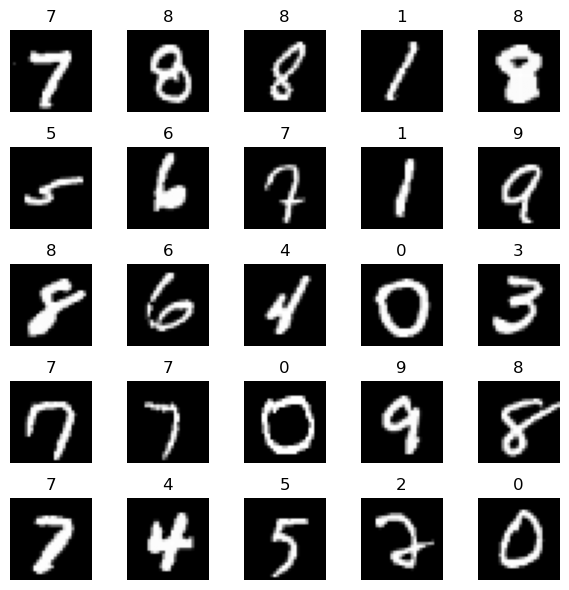

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# data visualization

### **Model setup**

We introduce a latent variable $ z \in \mathbb{R}^m $ that captures continuous variations in handwriting style.
The joint distribution is defined as

$$
p_\theta(x, z \mid y) = p_\theta(x \mid z, y) p(z),
$$

where $ p(z) = \mathcal{N}(0, I) $ is a fixed Gaussian prior.

* **Decoder (generative model):** $ p_\theta(x \mid z, y) $ reconstructs the image given latent code $z$ and label $y$.
* **Encoder (inference model):** we approximate the true posterior $ p_\theta(z \mid x, y) $ with

$$
q_\phi(z \mid x, y) = \mathcal{N}\big(\mu_\phi(x, y), \mathrm{diag}(\sigma_\phi^2(x, y))\big).
$$



### **Derivation of the Conditional ELBO**

Our goal is to maximize the conditional log-likelihood of the data:

$$
\log p_\theta(x \mid y).
$$

Since this is intractable, we derive a lower bound (the **conditional ELBO**):

$$
\log p_\theta(x \mid y)
\ge
\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]

D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

### **Training objective**

The right-hand side is the objective we actually optimize.
We **maximize** the ELBO with respect to parameters $\theta$ and $\phi$, or equivalently, **minimize** the negative ELBO (which is used as the loss in code):

$$
\mathcal{L}_{\text{CVAE}}(x, y)
= -\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]
+ D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

- The first term (reconstruction loss) ensures that decoded samples resemble the input image.
- The second term (KL divergence) regularizes the latent distribution so that it stays close to the Gaussian prior, which keeps sampling stable during generation.




In [ ]:
# models
class Encoder(nn.Module):
    pass

class Decoder(nn.Module):
    pass

class CVAE(nn.Module):
    def __init__(self, y_dim=..., z_dim=...):
        super().__init__()
        self.encoder = Encoder(y_dim, z_dim)
        self.decoder = Decoder(y_dim, z_dim)

    def reparameterize(self, mu, logvar):
        pass

    def forward(self, x, y):
        pass


In [ ]:
# loss
def loss_function(x_recon, x, mu, logvar):
    # reconstruction loss (binary cross-entropy)
    recon_loss = ...

    # KL divergence between q(z|x,y) and N(0,I)
    kl_loss = ...

    return recon_loss + kl_loss, recon_loss, kl_loss

In [ ]:
# training
# dataloader
batch_size = ...
train_loader = DataLoader(..., batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(...).to(device)
optimizer = ...

epochs = ...
### don't edit this !!!
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x, y)

        loss, recon_loss, kl_loss = loss_function(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    n = len(train_loader.dataset)
    print(f"Epoch {epoch:02d}  Loss per example: {total_loss / n:.4f}  Recon: {total_recon / n:.4f}  KL: {total_kl / n:.4f}")


Epoch 01  Loss per example: 128.2520  Recon: 103.9498  KL: 24.3022
Epoch 02  Loss per example: 104.2894  Recon: 79.9594  KL: 24.3300
Epoch 03  Loss per example: 101.2320  Recon: 77.6095  KL: 23.6225
Epoch 04  Loss per example: 99.7292  Recon: 76.4497  KL: 23.2795
Epoch 05  Loss per example: 98.4509  Recon: 75.5385  KL: 22.9124
Epoch 06  Loss per example: 97.6006  Recon: 74.9657  KL: 22.6349
Epoch 07  Loss per example: 96.7889  Recon: 74.4356  KL: 22.3533
Epoch 08  Loss per example: 96.0821  Recon: 73.9127  KL: 22.1694
Epoch 09  Loss per example: 95.5225  Recon: 73.5188  KL: 22.0037
Epoch 10  Loss per example: 95.0907  Recon: 73.2644  KL: 21.8263


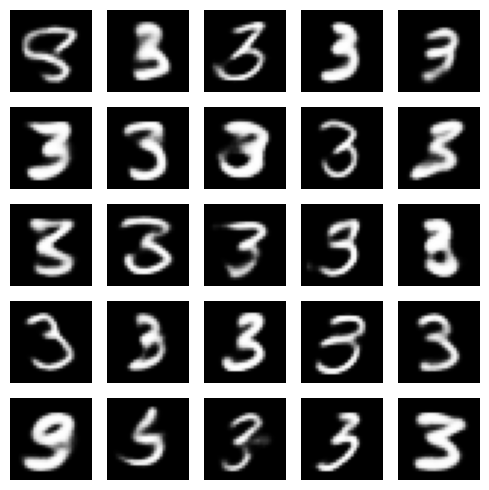

In [ ]:
# model inferencing
model.eval()
with torch.no_grad():
    # choose the digit you want to generate
    digit = ...   # for example, "2"
    n = ...
    y = ...

    # match the latent size to your model (z_dim=32)
    z = ...

    # decode to images
    x_gen = model.decoder(z, y).cpu()

# visualize

### Student ID Generation
After training your CVAE model, define a function that takes your 9-digit student ID as input and generates one digit per number in your ID. Each digit must be conditioned on its corresponding label (0–9). Arrange the generated digits horizontally in a 1×9 grid to visually display your complete student ID as a sequence of generated MNIST-style digits. Include this final generated image in your report.

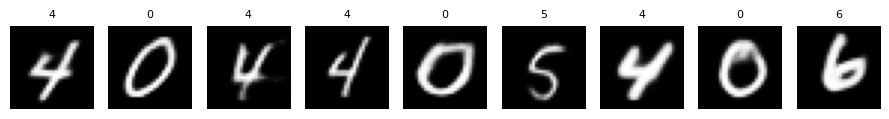

In [ ]:
def generate_student_digits(model, student_id, device='cpu'):
    pass

generate_student_digits(model, 404405406, device)

### **Latent Space Exploration**
To demonstrate that your CVAE has learned a meaningful latent representation, write a function that visualizes the latent space of the model.
Select **two random latent directions** in $z$-space, fix a target digit label $y$, and generate a **9×9 grid** of samples by varying these two directions from negative to positive values.
The center of the grid should correspond to $z = 0$ (the mean latent vector), while moving along the axes explores different variations of handwriting style.
After visualizing, **describe what each direction appears to represent**—for example, changes in stroke thickness, slant, or digit shape—and discuss whether the transformations look smooth and interpretable.


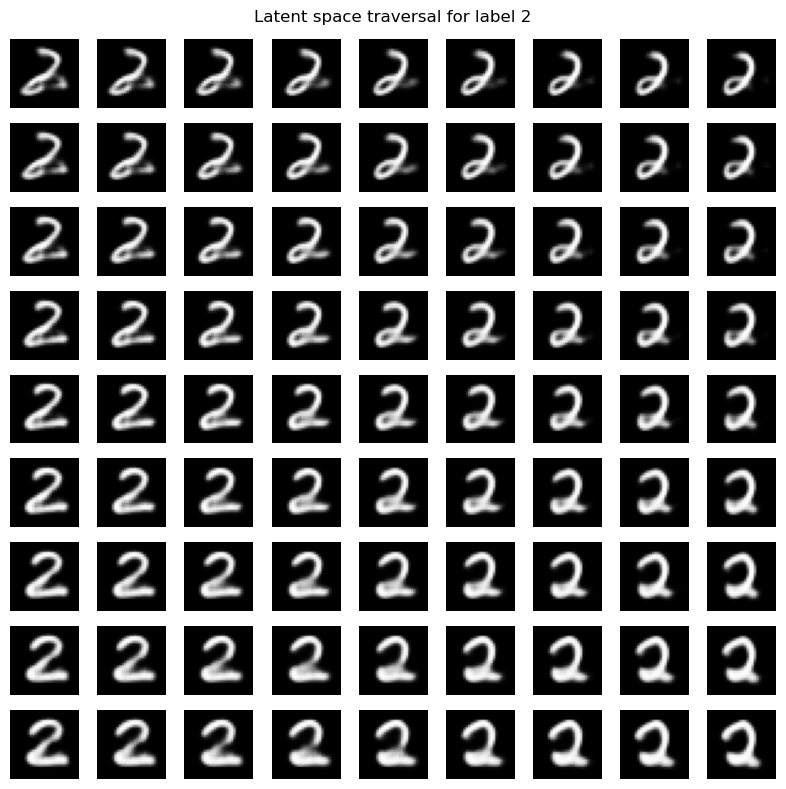

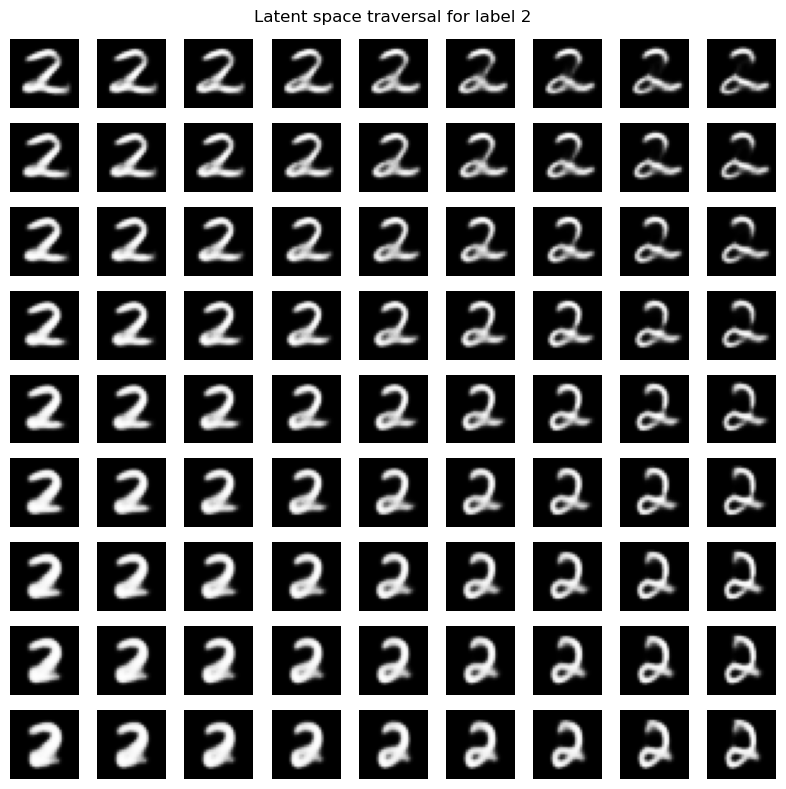

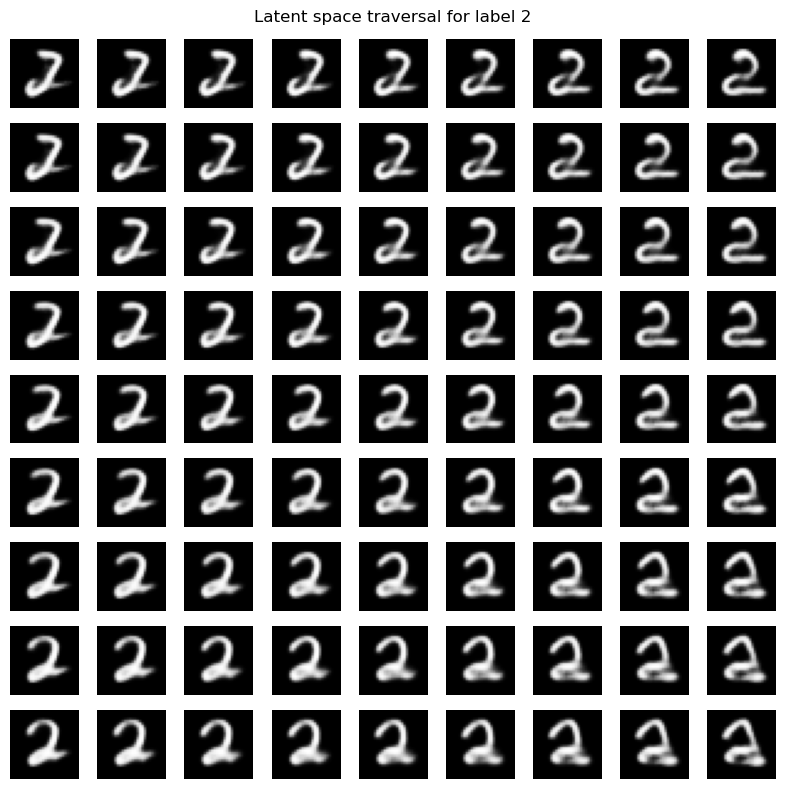

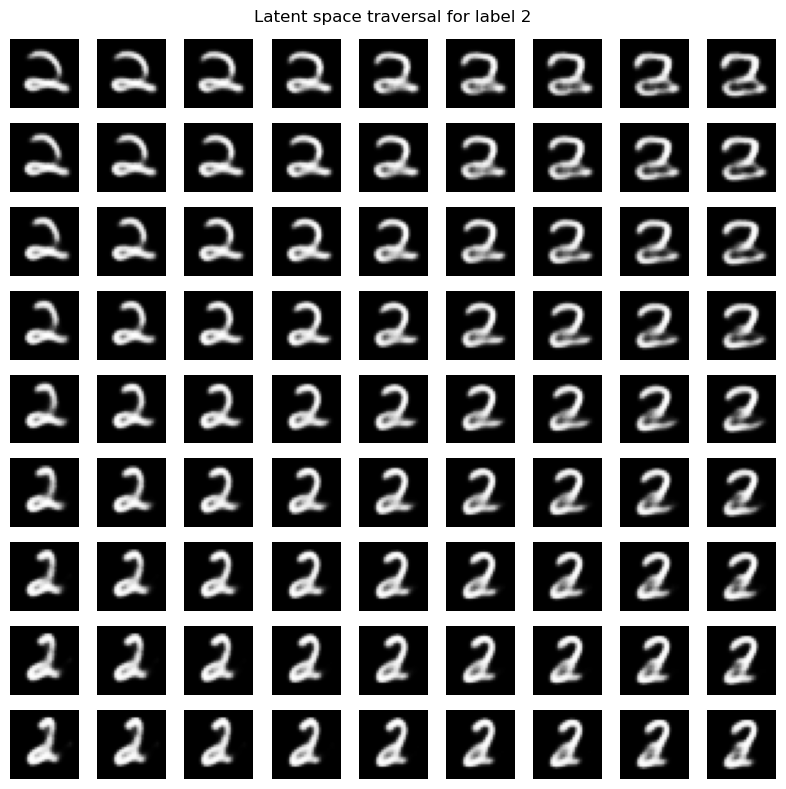

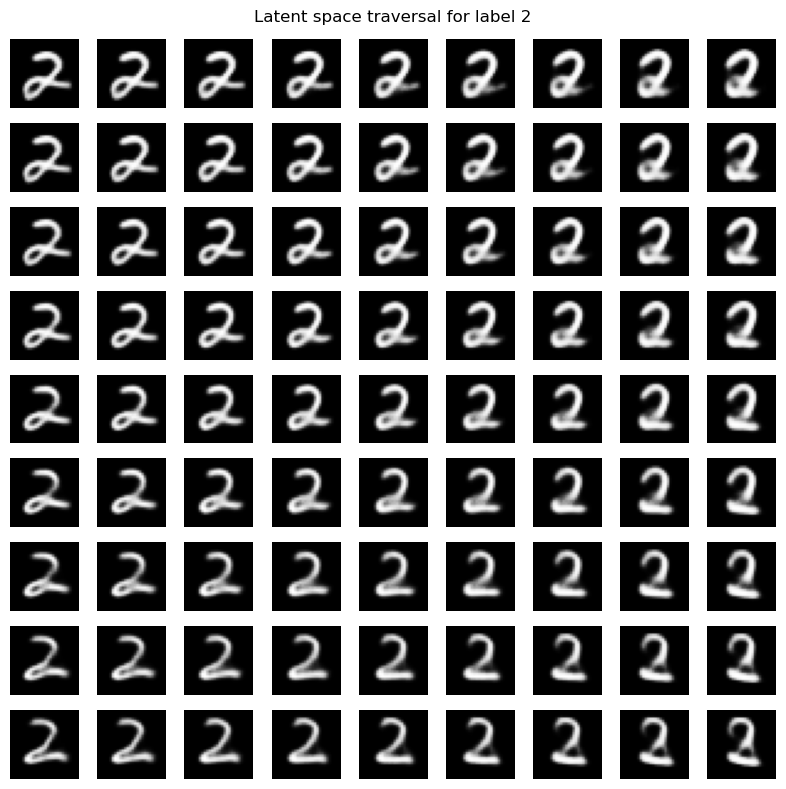

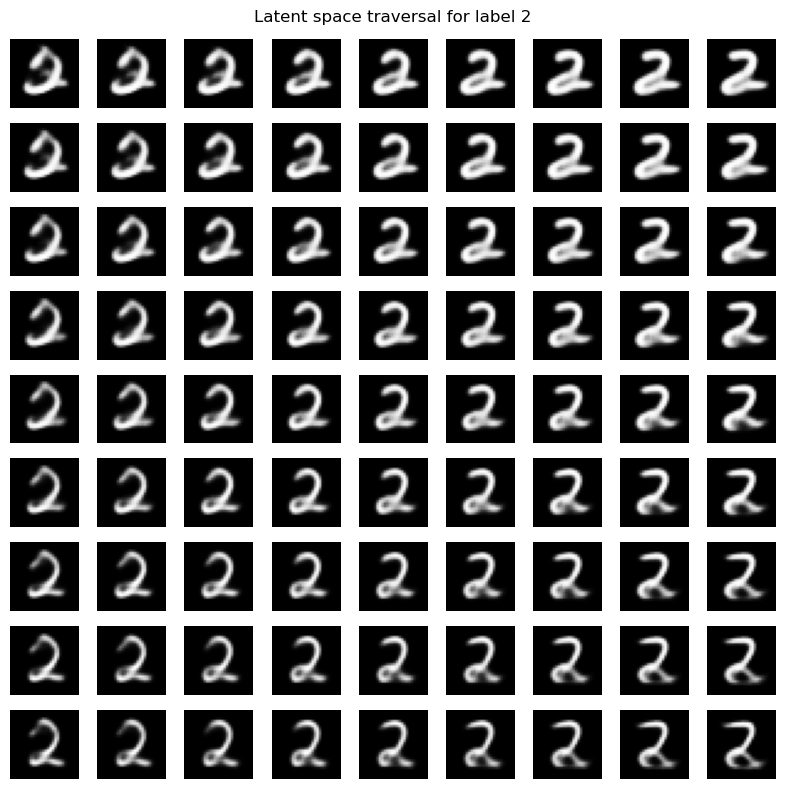

In [ ]:
def visualize_latent_space(model, y_label, z_dim=..., grid_size=..., scale=..., device='cpu'):
    pass

visualize_latent_space(...)
visualize_latent_space(...)
visualize_latent_space(...)
visualize_latent_space(...)
visualize_latent_space(...)
visualize_latent_space(...)



### **Bonus – Style-Controlled Student ID Generation**
Extend your CVAE to allow **style control** along a latent dimension.
Write a function that takes your **9-digit student ID** as input and generates one digit per number, arranged in a single row.
Additionally, for each digit, gradually vary the “style” dimension from thin to thick (or light to bold) as you move across the row, so that the same digit shows different styles.
Include the resulting image in your report and briefly describe how the style changes are reflected in the generated digits.
